# Capstone Project: House Price Prediction
## Model Building

### Overview

In the previous parts of this project, I have taken care of missing values and added some new columns using existing columns. I still need to do the followings before building machine learning models in the first section.
- Make more new columns
- Remove unnecessary columns
- One-hot encoding for non-numerical columns
- Split training-test sets

After preparing data, the following 5 machine learning algorithms will be used to build models and compared
- Ridge regression (Linear regression) 
- Random  Forest
- XGBoost
- LightGBM
- Neural Network

I chose ridge regression as a base model to be compared with other more complex models of interest. Tree-based ensemble models have been winning models in many competitions like Kaggle, so I decided to try Random Forest, XGBoost, and LightGBM. To add some fun variation in the choice of models, I decided to try Neural Network models at the end.

<a id= 'Section0'></a>

### Table of Contents

1. <a href='#Section1'>Prepare data</a>.
2. <a href='#Section2'>Ridge Regression (Linear Regression)</a>
3. <a href='#Section3'>Random Forest</a>
4. <a href='#Section4'>XGBoost</a>
5. <a href='#Section5'>LighGBM</a>
6. <a href='#Section8'>Conclusion</a>


<a id= 'Section1'></a>

## 1. Prepare data

In [23]:
# import basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

# import machine learning packages
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [5]:
# Load data prepared in the earlier parts
df = pd.read_csv('df_house_zipcode.csv',index_col=0)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,cost_of_living_score,diversity_score,good_for_families_score,health_fitness_score,housing_score,jobs_score,nightlife_score,outdoor_activities_score,public_schools_score,weather_score
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,2.0,4.3,3.0,4.0,2.0,2.7,3.7,4.0,3.0,3.0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,1.7,4.0,3.7,4.3,2.0,2.7,4.0,4.0,3.7,3.0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,2.0,3.7,4.0,4.3,3.0,3.3,3.7,4.0,4.3,3.0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,2.0,3.3,4.0,4.0,2.7,3.3,3.0,4.0,3.7,3.0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,2.0,3.0,4.3,4.3,3.3,3.7,2.7,4.0,4.3,2.7


In [6]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sales_order',
       'commute_grade', 'cost_of_living_grade', 'diversity_grade',
       'good_for_families_grade', 'health_fitness_grade', 'housing_grade',
       'jobs_grade', 'nightlife_grade', 'outdoor_activities_grade',
       'public_schools_grade', 'weather_grade', 'commute_score',
       'cost_of_living_score', 'diversity_score', 'good_for_families_score',
       'health_fitness_score', 'housing_score', 'jobs_score',
       'nightlife_score', 'outdoor_activities_score', 'public_schools_score',
       'weather_score'],
      dtype='object')

The data frame has 21597 observations and 44 columns.

### Make  new columns

In the EDA part, I found house prices go down from May to January or Febrary next year and then go back up till April or May. To use this seasonal fluctuation of house prices as a feature, 'sold_month' column (categorical) will be created from the column 'date' for sold dates (to be removed). Since this data set has only one year of house sales records, year will be ignored.

In [7]:
# Extract month from date column
from calendar import month_name

df.date = pd.to_datetime(df.date)
df['sold_month'] = df.date.map(lambda x: month_name[x.month])

In [8]:
df.sold_month.unique()

array(['October', 'December', 'February', 'May', 'June', 'January',
       'April', 'March', 'July', 'August', 'November', 'September'],
      dtype=object)

The most of values of 'yr_renovated' (renovated years) were missing and I filled the missing values with built years before. I will remove the yr_renovated columns, but a new column 'renovated' will be added to show whether a house is renovated or not.

In [9]:
# 1 for renovated houses and 0 for else
df['renovated'] = (df.yr_built != df.yr_renovated)*1

A new column 'zip98039' will be generated to show whether a house is in zipcode 98039 or not. I found that houses in 98039 (Medina, WA) are significantly more expensive that houses not in 98039 in the inferential statistics part of this project. 

In [10]:
# 1 for houses in 98039 and 0 for else
df['zip98039'] = (df.zipcode == 98039)*1

### Remove unnecessary columns

In [11]:
# Delete some columns from the dataframe
df = df.drop(['id','date', 'yr_renovated', 'zipcode', 
              'commute_grade', 'cost_of_living_grade', 'diversity_grade',
              'good_for_families_grade', 'health_fitness_grade', 'housing_grade',
              'jobs_grade', 'nightlife_grade', 'outdoor_activities_grade',
              'public_schools_grade', 'weather_grade'], axis=1)

- The 'date' and 'yr_renovated' are removed since they were transformed to new columns, 'sold_month' and 'renovated' in the previous section.
- 'zipcode' is removed since it has too many levels for one-hot encoding and was used to make new columns ending with 'grade'.
- The columns ending with 'grade' were were dropped since they were already transformed to new numerical columns ending with 'score' in the data wrangling part. 
- I could have removed more columns such as 'sqft_living15', 'sqft_lot15', and 'sqft_basement' to avoid multicolinearity. However, I found removing them do not help my preidctions in general, so I decided to keep them. More delicate feature selection method might find removing them or some other features beneficial.

In [12]:
# columns left
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'sales_order', 'commute_score', 'cost_of_living_score',
       'diversity_score', 'good_for_families_score', 'health_fitness_score',
       'housing_score', 'jobs_score', 'nightlife_score',
       'outdoor_activities_score', 'public_schools_score', 'weather_score',
       'sold_month', 'renovated', 'zip98039'],
      dtype='object')

Now there are 42 columns left, 1 target and 41 features.

### One-hot encoding

In [13]:
# one-hot encoding for categorical columns
df = pd.get_dummies(df, drop_first=True) # April column was dropped
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sold_month_December,sold_month_February,sold_month_January,sold_month_July,sold_month_June,sold_month_March,sold_month_May,sold_month_November,sold_month_October,sold_month_September
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,0,0,0,0,0,0,0,1,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,1,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,0,1,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,1,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,0,1,0,0,0,0,0,0,0,0


The categorical column 'sold_month' was transformed to 11 columns by one-hot encoding. The column for April was dropped using the argument 'drop_first=True' to avoid multicolinearity.

### Split training-test sets

In [14]:
# Predictors X and target y
y = df.price.values
X = df.drop('price', axis=1).values

In [15]:
# check the size of y
len(y)

21597

In [16]:
# check the size of X
len(X), len(X[0])

(21597, 41)

In [17]:
# Split training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

20% of rows were saved for testing and 80% left will be used for training.

In [95]:
# Make function that print the tuned parameters and score
def print_results(cv):
    print("Best Hyper-parameters found: {}".format(cv.best_params_)) 
    print("Best RMSE score on development set: {:.0f}".format(np.sqrt(-cv.best_score_)))
    RMSE = np.sqrt(-cv.score(X_test, y_test))
    print("\nRMSE on test set: {:.0f}".format(RMSE))
    r_squared = r2_score(y_test,cv.predict(X_test))
    print("R^2 on test set: {:.4f}".format(r_squared))

- The negative mean squared error built in GridSearchCV will be used for scoring and optimizing hyper-parmeter values. However, I will report the root mean squared error (RMSE), just square root of mean squared error, since the number in dollars makes more sense.  
- The r-squared score for the test set was added just to feel how much variability in house prices is explained by a model.
- Note that RMSE on the deveopment set is a square root of averaged MSE over n folds (n=5 typically). I think this is a fine method since the calculation is like getting the average of squared errors over all data and then taking a square root. The other method can be getting RMSE from each fold and averaging them (this will be smaller), but I do not think this is a right method. I realized RMSE is tricky and picky in theses situations unlike MAE. You will see a similar and more serious problem in my dicussion on the result printing function for Neural Network, print_result_NN, where smaller batches complicates this matter.

In [19]:
# This is an example to my last note above.
# Let's say there are errors 1,2,3 in the first fold and  4,5,6 in the second fold
print("first method: {:.4f}".format(np.sqrt(((1+4+9)/3+(16+25+36)/3)/2)))
print("second method: {:.4f}".format((np.sqrt((1+4+9)/3)+np.sqrt((16+25+36)/3))/2))
print("without folds: {:.4f}".format(np.sqrt(((1+4+9+16+25+36)/6))))

first method: 3.8944
second method: 3.6132
without folds: 3.8944


In [16]:
# Adjusted R-squared 
#def adj_r2_score(model,X, y):
#    n_obs = len(X)
#    n_features = len(X[0])
#    r2 = r2_score(y, model.predict(X))
#    adj_r2 = 1-(1-r2)*(n_obs-1)/(n_obs-n_features-1)
#    print("Adjusted R^2 on test set: {:.4f}".format(adj_r2))

<a id= 'Section2'></a>

## 2. Ridge Regression (Linear Regression)

In [133]:
# Check assumptions of linear regression
from statsmodels.formula.api import ols

predictor_list = df.columns[1:] 
predictors='+'.join(predictor_list)
m = ols('price ~'+ predictors,df).fit()
#print(m.summary())

In the inferential statistics part of this project and in the right above cell using statsmodels package, I found many features are highly correlated (multicolinearty) and there are heteroscedasticity. These violate two of the assumptions for the linear regression model. However, a liner regression model is just a baseline model to be compared with the other complex models of my interest and I will not rely on any statistical significance in its result. Mutlicolinearity could be problematic for even other machine learning models especially when intepreting feature importances. I will interprete them with caution.

In [145]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

In [18]:
# Ridge Regression tuning alpha
steps = [('lr', Ridge(normalize=True, random_state=42, solver='auto'))] #normalize=True for scaling
pl = Pipeline(steps) 
param_grid = {'lr__alpha':[.001,.01,.1,1]}
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {'lr__alpha': 0.001}
Best RMSE score on development set: 178083

RMSE on test set: 180471
R^2 on test set: 0.7496


First, I tried Ridge regression with feature scaling (normalize=True). Scaling is necessary for Ridge regression since the regularization term in its cost function uses feature weights. I found very small regularization (small alpha) is required and this could be because the linear model is too simple and underfitting our data. Let's try the pure linear regression without any regularization to check if it is even better.

In [156]:
%%time
# Linear Regression
lr = LinearRegression(normalize=True, n_jobs=-1)
param_grid = {}
cv = GridSearchCV(lr, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {}
Best RMSE score on development set: 178080

RMSE on test set: 180464
R^2 on test set: 0.7497
Wall time: 507 ms


In [146]:
lr = LinearRegression(normalize=True, n_jobs=-1)
param_grid = {}
cv = GridSearchCV(lr, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {}
Best RMSE score on development set: 178080

RMSE on test set: 180464
R^2 on test set: 0.7497


Linear regression gives a slightly better result than Ridge regression. This means we need a more complex model that can reduce bias and capture more variance. 

<a id= 'Section3'></a>

## 3. Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [106]:
%%time
# Tuning hyperparameters
rf = RandomForestRegressor(random_state=42, n_jobs=-1,n_estimators=1000)
param_grid = {'max_features':['auto','sqrt'],
             'max_depth':[None, 80, 100, 120], # also tried 'max_depth':[None,10,20,50],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3, 4]}
cv = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best RMSE score on development set: 131775

RMSE on test set: 125872
R^2 on test set: 0.8782
Wall time: 1h 29min 2s


I found all the default values for the hyperparameters are actually the best and this means no regularization for Random Forest  is necessary for my data.

In [120]:
# with feature scaling
rf = RandomForestRegressor(random_state=42, n_jobs=-1,n_estimators=1000)
steps = [('scale',StandardScaler()), ('rf', rf)] #
pl = Pipeline(steps)
param_grid = {} # found default values are the best above
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {}
Best RMSE score on development set: 131762

RMSE on test set: 125902
R^2 on test set: 0.8782


Feature scaling is usually unnessary for tree-based ensemble methods, but I checked if it helps (since sometimes it does). I found scaling did not improve the performance.

#### Best RF model found

In [155]:
%%time
# Best model for Random Forest 
rf = RandomForestRegressor(random_state=42, n_jobs=-1,n_estimators=1000)  
param_grid = {}
cv = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {}
Best RMSE score on development set: 131775

RMSE on test set: 125872
R^2 on test set: 0.8782
Wall time: 2min 44s


- This is the best Random Forest (RF) model found above. Feature scaling is removed since I found it does not help. The hyperparameter for the numbmer of estimators, n_estimators=500, was also tested, but I found 1000 is better.
- The result shows no regularization for Random Forest was necessary. It used all features (max_features=auto) and as many as depth of tree needed (max_depth=None) and it could keep splitting data without restriction (min_samples_leaf=1 and min_samples_split=2). 
- The root mean squared error (RMSE) on the test set is reduced to 125872 from 180464, RMSE of the Linear regression model. This is a huge (43%) improvement !! 
- The R-squared score on the test set shows 87.82% of variability in the data is explained by this RF model.
- It took 2min 44sec to run the final model.

In [143]:
# Save the trained model 
rf_trained = cv
file_name='rf_trained.sav'
pickle.dump(rf_trained, open(file_name,'wb'))
# Load the trained model from file (for later)
#rf_trained = pickle.load(open('rf_trained.sav','rb'))

<a id= 'Section4'></a>

## 4. XGBoost

In [20]:
import xgboost
from xgboost.sklearn import XGBRegressor

In [428]:
# Tuning hypterparameters
xgb = XGBRegressor(random_state=42, n_jobs=-1) #n_estimators=100 by default
param_grid = {'eta':[.001],'max_depth':[6,7,8], 'subsample':[.9,1], 
              'colsample_bytree':[.6,.7,.8,.9]}
cv = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {'colsample_bytree': 0.7, 'eta': 0.001, 'max_depth': 7, 'subsample': 1}
Best RMSE score on development set: 119980

RMSE on test set: 121299
R^2 on test set: 0.8869


It takes a while to narrow down the ranges fo hyperparameters this much and this tuning process of XBBoost was much more difficult than RF! I was somewhat lost until I realized that the regularization parameters lambda and alpha (same as reg_lambda and reg_alpha) are not used in the default gbtree booster I'm using. I will further tune hyperparameters and increase n_estimators.

In [429]:
# Increased n_estimator (500) with best parameters found so far
xgb = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=500)
param_grid = {'eta':[.001],'max_depth':[7], 'subsample':[1], 'colsample_bytree':[.7]}
cv = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {'colsample_bytree': 0.7, 'eta': 0.001, 'max_depth': 7, 'subsample': 1}
Best RMSE score on development set: 118284

RMSE on test set: 118520
R^2 on test set: 0.8920


In [121]:
# Increased n_estimator (1000) with best parameters found so far
xgb = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=1000)
param_grid = {'eta':[.001],'max_depth':[7], 'subsample':[1], 'colsample_bytree':[.7]}
cv = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {'colsample_bytree': 0.7, 'eta': 0.001, 'max_depth': 7, 'subsample': 1}
Best RMSE score on development set: 118284

RMSE on test set: 118796
R^2 on test set: 0.8915


In [146]:
# improvement on RMSE after doubling n_estimator
(121299-118520)/121299*100

2.2910329021673714

Increasing the number estimators to 500 from 100 improved the performance a little (2.29%), but increasin it to 1000 didn't help. I will tune the number of estimators below.

In [122]:
# tuining n_estimator with best parameters found
xgb = XGBRegressor(random_state=42, n_jobs=-1)
param_grid = {'eta':[.001],'max_depth':[7], 'subsample':[1], 'colsample_bytree':[.7],
             'n_estimators':[500,600,700,800,900]}
cv = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {'colsample_bytree': 0.7, 'eta': 0.001, 'max_depth': 7, 'n_estimators': 800, 'subsample': 1}
Best RMSE score on development set: 118266

RMSE on test set: 118782
R^2 on test set: 0.8915


I found that 800 is the best number of estimators. Now I will try feature scaling.

#### With feature scaling

In [138]:
# More tuning with feature scaling
xgb = XGBRegressor(random_state=42, n_jobs=-1)
steps = [('scale',StandardScaler()), ('xgb', xgb)] 
pl = Pipeline(steps)
param_grid = {'xgb__eta':[.001],'xgb__max_depth':[6,7,8],
              'xgb__subsample':[.9,1], 'xgb__colsample_bytree':[.7,.8,.9],
              'xgb__n_estimators':[800,900,1000]}
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {'xgb__colsample_bytree': 0.7, 'xgb__eta': 0.001, 'xgb__max_depth': 6, 'xgb__n_estimators': 800, 'xgb__subsample': 1}
Best RMSE score on development set: 117382

RMSE on test set: 119559
R^2 on test set: 0.8901


In [160]:
# More tuning with feature scaling
xgb = XGBRegressor(random_state=42, n_jobs=-1)
steps = [('scale',StandardScaler()), ('xgb', xgb)] #
pl = Pipeline(steps)
param_grid = {'xgb__eta':[.001],'xgb__max_depth':[5,6,7],
              'xgb__subsample':[.9,1], 'xgb__colsample_bytree':[.6,.7,.8],
              'xgb__n_estimators':[700,800,900]}
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {'xgb__colsample_bytree': 0.8, 'xgb__eta': 0.001, 'xgb__max_depth': 5, 'xgb__n_estimators': 900, 'xgb__subsample': 1}
Best RMSE score on development set: 116953

RMSE on test set: 117300
R^2 on test set: 0.8942


In [163]:
# More tuning with feature scaling
xgb = XGBRegressor(random_state=42, n_jobs=-1)
steps = [('scale',StandardScaler()), ('xgb', xgb)] #
pl = Pipeline(steps)
param_grid = {'xgb__eta':[.001],'xgb__max_depth':[4,5,6,7],
              'xgb__subsample':[1], 'xgb__colsample_bytree':[.6,.7,.8,.9],
              'xgb__n_estimators':[900,1000]}
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {'xgb__colsample_bytree': 0.8, 'xgb__eta': 0.001, 'xgb__max_depth': 5, 'xgb__n_estimators': 900, 'xgb__subsample': 1}
Best RMSE score on development set: 116953

RMSE on test set: 117300
R^2 on test set: 0.8942


In [179]:
# RMSE improvement by feature scaling
print(round((118782-117300)/118782*100, 2),'%')

1.25 %


Before this last hyperparamter tuning, I tried many other hypterparameter values including lower n_estimators and lower subsample, but this last one shows the best tuning result so far. Feature scaling is again unnessary for tree-based ensemble methods, but I checked again with hyperparameter tuning and found scaling actually improved the performance slightly (1.25% drop in RMSE).

Almost done! I tried randomized search for the very last check for XGBoost, the best tree-based model I have found.

In [76]:
import scipy.stats as st

param_grid = { 
    "xgb__max_depth": range(3,10),
    "xgb__colsample_bytree": [.5,.6,.7,.8,.9,1],
    "xgb__subsample": [.5,.6,.7,.8,.9,1],
    "xgb__gamma": st.uniform(0, 5),
    "xgb__min_child_weight": range(1,10)
}

xgb = XGBRegressor(eta=.001, n_estimators=900, random_state=42, n_jobs=-1)  

In [77]:
%%time
steps = [('scale',StandardScaler()), ('xgb', xgb)] 
pl = Pipeline(steps)
cv = RandomizedSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error', 
                        n_jobs=-1, n_iter=200)
cv.fit(X_train,y_train)

Wall time: 1h 58min 41s


In [78]:
xgb_trained_RS = cv
file_name='xgb_trained_RS.sav'
pickle.dump(xgb_trained_RS, open(file_name,'wb'))
print_results(cv)

Best Hyper-parameters found: {'xgb__colsample_bytree': 0.6, 'xgb__gamma': 4.96437452790771, 'xgb__max_depth': 4, 'xgb__min_child_weight': 1, 'xgb__subsample': 0.8}
Best RMSE score on development set: 116009
Best RMSE score on development set: 116009

RMSE on test set: 117546
R^2 on test set: 0.8938


This result is good, but RMSE is still slightly higher than the best RMSE (117300) by grid search. I will reduce the range of gamma and min_child_weight and run again to see if it helps radomized search.

In [79]:
param_grid = { 
    "xgb__max_depth": st.randint(3,10),
    "xgb__colsample_bytree": [.5,.6,.7,.8,.9,1],
    "xgb__subsample": [.5,.6,.7,.8,.9,1],
    "xgb__gamma": st.uniform(0, .5),
    "xgb__min_child_weight": st.randint(1,6)
}

xgb = XGBRegressor(eta=.001, n_estimators=900, random_state=42, n_jobs=-1)  

In [80]:
%%time
steps = [('scale',StandardScaler()), ('xgb', xgb)] 
pl = Pipeline(steps)
cv = RandomizedSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error', 
                        n_jobs=-1, n_iter=200)
cv.fit(X_train,y_train)

Wall time: 1h 56min 54s


In [81]:
print_results(cv)

Best Hyper-parameters found: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.45420397229757953, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__subsample': 0.7}
Best RMSE score on development set: 115582
Best RMSE score on development set: 115582

RMSE on test set: 118476
R^2 on test set: 0.8921


No, I still could not find a better combination of hyperparameters after 400 iteranations of randmozied search. Randomized search found lower RMSE for the validation set than grid search, but RMSE on the test was higher. I found I prefer grid search than randomized search since I can do coarse to finer search and check all combinations I want to see. It seems the default values for gamma (0) and min_child_weight (1) seem to work better, so I will stop tuning them. The three hyperparameters left make only 252 combinations, I will go back to GridSearchCV to check all combinations.

In [82]:
param_grid = { 
    "xgb__max_depth": range(3,10),
    "xgb__colsample_bytree": [.5,.6,.7,.8,.9,1],
    "xgb__subsample": [.5,.6,.7,.8,.9,1],
}

xgb = XGBRegressor(eta=.001, n_estimators=900, random_state=42, n_jobs=-1)  

In [83]:
%%time
steps = [('scale',StandardScaler()), ('xgb', xgb)] 
pl = Pipeline(steps)
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv.fit(X_train,y_train)

Wall time: 2h 28min 17s


In [84]:
print_results(cv)

Best Hyper-parameters found: {'xgb__colsample_bytree': 1, 'xgb__max_depth': 5, 'xgb__subsample': 0.6}
Best RMSE score on development set: 114288
Best RMSE score on development set: 114288

RMSE on test set: 116750
R^2 on test set: 0.8952


I finally found a slightly better RMSE! I am going to briefly check if applying PCA improves the model.

In [120]:
%%time
# PCA
from sklearn.decomposition import PCA
xgb = XGBRegressor(random_state=42, n_jobs=-1)
steps = [('scale',StandardScaler()), ('pca', PCA()), ('xgb', xgb)] 
pl = Pipeline(steps)
param_grid = {'xgb__eta':[.001],'xgb__max_depth':[5],
              'xgb__subsample':[.6], 'xgb__colsample_bytree':[1],
              'xgb__n_estimators':[900],
              'pca__n_components':range(10,42)}
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {'pca__n_components': 40, 'xgb__colsample_bytree': 1, 'xgb__eta': 0.001, 'xgb__max_depth': 5, 'xgb__n_estimators': 900, 'xgb__subsample': 0.6}
Best RMSE score on development set: 140476

RMSE on test set: 128367
R^2 on test set: 0.8733
Wall time: 24min 14s


I tried the number of components of PCA from 10 to 41, but PCA did not improve RMSE at all. Tuning both n_components for PCA and  hyperparameters for XGBoost might find a better combination of hyperparameters, but I will stop here.  

#### Best XGBoost model found

In [96]:
# Best model for XGBoost
xgb = XGBRegressor(random_state=42, n_jobs=-1)
steps = [('scale',StandardScaler()), ('xgb', xgb)] 
pl = Pipeline(steps)
param_grid = {'xgb__eta':[.001],'xgb__max_depth':[5],
              'xgb__subsample':[.6], 'xgb__colsample_bytree':[1],
              'xgb__n_estimators':[900]}
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)
cv.fit(X_train,y_train)

print_results(cv)

Best Hyper-parameters found: {'xgb__colsample_bytree': 1, 'xgb__eta': 0.001, 'xgb__max_depth': 5, 'xgb__n_estimators': 900, 'xgb__subsample': 0.6}
Best RMSE score on development set: 114288

RMSE on test set: 116750
R^2 on test set: 0.8952


In [97]:
# Save the trained model 
xgb_trained = cv
file_name='xgb_trained.sav'
pickle.dump(xgb_trained, open(file_name,'wb'))
#xgb_trained = pickle.loads(open(file_name,'rb'))

In [98]:
# RMSE improvement from Random Forest
(125872-116750)/125872*100

7.247044616753527

- XGBoost showed the better performance than Random Forest!!! The root mean squared error (RMSE) of the best XGBoost model on the test set is 116750, which corresponds to 7.25% improvement from RMSE of the best Random Forest model, 125872.
- The R-squared score on the test set shows 89.52% of variability in the data is explained by this best XGBoost model.

- It took around 43.4 seconds to run the final model. This is so much faster than Random Forest (2min 44sec)! However, hyperparameter tuning for XGBoost was much more challenging and took more time.

<a id= 'Section5'></a>

## 5. LightGBM

In [22]:
import lightgbm as lgb

In [399]:
#d_train = lightgbm.Dataset(X_train, label=y_train)

In [402]:
# Tuning hyperparameters n_estimators=500
lgbm = lgb.LGBMRegressor(boosting_type="gbdt",random_state=42, 
                         bagging_freq=15, learning_rate=0.01,
                         n_estimators=500) # alias of num_iterations
param_grid = {'max_depth':[10,11,12],'num_leaves':[125,150,200], 
              'feature_fraction':[.4,.5,.6],'bagging_fraction':[.8,.9,1.] }
cv = GridSearchCV(lgbm, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)

print_results(cv)

Best Hyper-parameters found: {'bagging_fraction': 0.9, 'feature_fraction': 0.5, 'max_depth': 12, 'num_leaves': 150}
Best RMSE score on development set: 122594

RMSE on test set: 122762
R^2 on test set: 0.8842


I tried a lot of more hyperparameter values (coarse to finer) and found this is one of the best finer combinations of hyperparameters with n_etimators=500. However, I found increasing n_esimators to 1000 makes the prediction better (see below).

In [153]:
# Finer tuning with n_estimators=1000
lgbm = lgb.LGBMRegressor(boosting_type="gbdt",random_state=42, 
                         bagging_freq=15, learning_rate=0.01,
                         n_estimators=1000) # alias of num_iterations
param_grid = {'max_depth':[13,14,15],'num_leaves':[150,160,170], 
              'feature_fraction':[.5],'bagging_fraction':[.9] }
cv = GridSearchCV(lgbm, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)

print_results(cv)

Best Hyper-parameters found: {'bagging_fraction': 0.9, 'feature_fraction': 0.5, 'max_depth': 15, 'num_leaves': 160}
Best RMSE score on development set: 120492

RMSE on test set: 120506
R^2 on test set: 0.8884


In [157]:
# more tuning with n_estimators=1000
lgbm = lgb.LGBMRegressor(boosting_type="gbdt",random_state=42, 
                         bagging_freq=15, learning_rate=0.01,
                         n_estimators=1000) # alias of num_iterations
param_grid = {'max_depth':[13,14,15,16],'num_leaves':[150,160,170,180], 
              'feature_fraction':[.4,.5,.6],'bagging_fraction':[.9,1.] }
cv = GridSearchCV(lgbm, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)

print_results(cv)

Best Hyper-parameters found: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'max_depth': 16, 'num_leaves': 180}
Best RMSE score on development set: 120333

RMSE on test set: 121738
R^2 on test set: 0.8861


I found overfitting with the high max_depth (16) and high number of leaves (180), so went back to lower values to find the better hyperparmeter values (see below).

In [159]:
# Best so far
lgbm = lgb.LGBMRegressor(boosting_type="gbdt",random_state=42, 
                         bagging_freq=15, learning_rate=0.01,
                         n_estimators=1000) # alias of num_iterations
param_grid = {'max_depth':[15],'num_leaves':[160], 
              'feature_fraction':[.5],'bagging_fraction':[.9] }
cv = GridSearchCV(lgbm, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)

print_results(cv)

Best Hyper-parameters found: {'bagging_fraction': 0.9, 'feature_fraction': 0.5, 'max_depth': 15, 'num_leaves': 160}
Best RMSE score on development set: 120492

RMSE on test set: 120506
R^2 on test set: 0.8884


This is the best output without feature scaling. I found 'gbdt' (Gradient Boosting Decision Tree) works better than 'rf' (Random Forest) for boosting type.

#### With feature scaling

In [162]:
# more tuning with lower number of leaves
lgbm = lgb.LGBMRegressor(boosting_type="gbdt",random_state=42, 
                         learning_rate=0.01, bagging_freq=15,
                         n_estimators=1000) # alias of num_iterations
param_grid = {'max_depth':[14,15,16],'num_leaves':[50,75,100], 
              'feature_fraction':[.4,.5,.6],'bagging_fraction':[.9,1.]}
cv = GridSearchCV(lgbm, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)
print_results(cv)

Best Hyper-parameters found: {'bagging_fraction': 0.9, 'feature_fraction': 0.5, 'max_depth': 16, 'num_leaves': 75}
Best RMSE score on development set: 120218

RMSE on test set: 120538
R^2 on test set: 0.8883


Some lower values for the number of leaves also gave similar results and this lower range of num_leaves worked better with feature scaling.

In [137]:
# with feature scaling
lgbm = lgb.LGBMRegressor(boosting_type="gbdt",random_state=42, 
                         learning_rate=0.01, bagging_freq=15,
                         n_estimators=1000) # alias of num_iterations
steps = [('scale',StandardScaler()), ('lgbm', lgbm)] #
pl = Pipeline(steps)
param_grid = {'lgbm__max_depth':[14,15,16],'lgbm__num_leaves':[50,75,100], 
              'lgbm__feature_fraction':[.4,.5,.6],'lgbm__bagging_fraction':[.9,1.]}
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)
print_results(cv)

Best Hyper-parameters found: {'lgbm__bagging_fraction': 1.0, 'lgbm__feature_fraction': 0.5, 'lgbm__max_depth': 15, 'lgbm__num_leaves': 75}
Best RMSE score on development set: 119955

RMSE on test set: 119439
R^2 on test set: 0.8903


In [178]:
# RMSE improvement by feature scaling
print(round((120506-119439)/120506*100, 2),'%')

0.89 %


I tried feature scaling again although it has no effect on RF and XGBoost. This time I had a success!!  Feature scaling with newly tuned hyperparameters slightly dereased RMSE from 120506 to 119439 (.89% improvement).

#### Best LightGBM model found

In [172]:
%%time
# Best model for LightGBM
lgbm = lgb.LGBMRegressor(boosting_type="gbdt",random_state=42, 
                         learning_rate=0.01, bagging_freq=15,
                         n_estimators=1000) # alias of num_iterations
steps = [('scale',StandardScaler()), ('lgbm', lgbm)] #
pl = Pipeline(steps)
param_grid = {'lgbm__max_depth':[15],'lgbm__num_leaves':[75], 
              'lgbm__feature_fraction':[.5],'lgbm__bagging_fraction':[1.]}
cv = GridSearchCV(pl, param_grid, cv=5, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)
print_results(cv)

Best Hyper-parameters found: {'lgbm__bagging_fraction': 1.0, 'lgbm__feature_fraction': 0.5, 'lgbm__max_depth': 15, 'lgbm__num_leaves': 75}
Best RMSE score on development set: 119955

RMSE on test set: 119439
R^2 on test set: 0.8903
Wall time: 18.5 s


In [99]:
# RMSE improvemnet from XGBoost
(116750-119439)/116750*100

-2.303211991434689

- LightGBM showed the similar performance with XGBoost (slightly worse)! The root mean squared error (RMSE) of the best LighGBM model on the test set is 119439, which corresponds to 2.30% increase from RMSE of the best XGBoost, 116750.
- The R-squared score on the test set shows 89.03% of variability in the data is explained by this best XGBoost model.
- It took only 18.5 seconds to run the final model. This is so much faster than both XGBoost (43.4sec) and Random Forest (2min 44sec)! However, hyperparameter tuning for LightGBM was slightly more challenging than XGBoost.

In [173]:
# Save the trained model (for later)
lgbm_trained = cv
file_name='lgbm_trained.sav'
pickle.dump(cv, open(file_name,'wb'))
#lgbm_trained = pickle.loads(open(file_name,'rb'))

#### Top 10 features

Here I will show top ten feature importances only for XGBoost and LightGBM since Random Forest had much worse performance than the two.

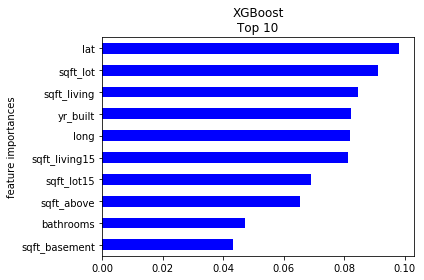

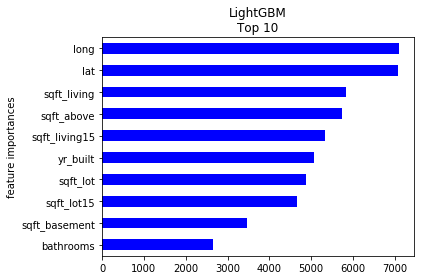

In [113]:
# XGBoost
importances = xgb_trained.best_estimator_.named_steps['xgb'].feature_importances_
plot_feature_importances('XGBoost', importances, df.columns[1:], num_features=10)
plt.tight_layout() # need for savefig
plt.savefig("Feature_importances_XGBoost_top10.png",format="png", dpi=300)

# LightGBM
importances = lgbm_trained.best_estimator_.named_steps['lgbm'].feature_importances_
plot_feature_importances('LightGBM', importances, df.columns[1:], num_features=10)
plt.tight_layout() # need for savefig
plt.savefig("Feature_importances_LightGBM_top10.png",format="png", dpi=300)

plt.show()

- The order of feature importances are different, but the top ten important features in the XGBoost and LightGBM models are exactly the same!!! 
- Both models have latitude and longitude within the top 5!! I noticed the longitude and latitude of houses are important in the price graph on the King County map in the EDA part of this project, but did not expect they are going to have such high feature importances. However, the order of feature importances should be carefully interpreted because there were multicollinearity which can make feature importances less reliable. For example, sqft_living and sqft_living15 have correlation over .7 and sqft_lot and sqft_lot15 have correlation over .9. I have seen that the features sqft_lot and sqft_living have higher importances in a XGBoost model than latitude if sqft_lot15, sqft_living15, and sqft_basement are removed from the model.   
- All 6 features representing square footages of house and lot area are included in top 10. They are 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_basement', and 'sqft_above'.
- The other two top 10 features are 'yr_built' and 'bathrooms'. 

In [141]:
#Built-in importance plot for boosting models (not pretty)

#from xgboost import plot_importance
#plot_importance(xgb_trained.best_estimator_.named_steps['xgb'])
#plt.show()

#from lightgbm import plot_importance
#plot_importance(lgbm_trained.best_estimator_.named_steps['lgbm'])
#plt.show()

<a id= 'Section8'></a>

## 6. Conclusion

#### Model building summary

- If necessary or helping, I performed feature scaling before fitting data into models.
- For cross validation and hyperparameter tuning, GridSearchCV was used except for Neural network models.
- I selected the root mean squared error (RMSE) for the evaluation metric.
- I used coarse to finer hyperparameter tuning to find the best model for each algorithm.
- I utilized early stopping for Neural Network models to reduce overfitting and save time.

#### Result summary

In [115]:
model_summary = pd.DataFrame({'RMSE_val':[178080,131775,114288,119955,118819], 
                            'RMSE_test':[180464,125872,116750,119439,116252], 
                            'R_squared':[0.7497,0.8782,0.8942,0.8903,0.8961],
                            'Time':['507 ms','2min 44s','43.4 s','18.5 s','22min 37s'],
                             'Scaling':[True, False,True,True,True]},
                           index=['LinearRegression', 'RandomForest','XGBoost','LightGBM','NeuralNetwork'])
model_summary = model_summary.sort_values(by=['RMSE_test'])
model_summary

,RMSE_test,RMSE_val,R_squared,Scaling,Time
NeuralNetwork,116252,118819,0.8961,True,22min 37s
XGBoost,116750,114288,0.8942,True,43.4 s
LightGBM,119439,119955,0.8903,True,18.5 s
RandomForest,125872,131775,0.8782,False,2min 44s
LinearRegression,180464,178080,0.7497,True,507 ms


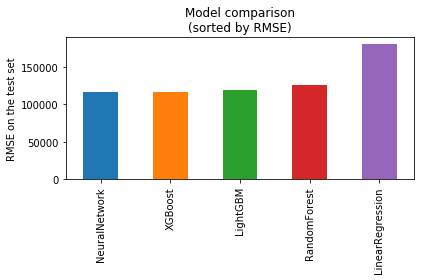

In [143]:
model_summary.RMSE_test.plot(kind='bar')
plt.ylabel('RMSE on the test set')
plt.title('Model comparison\n(sorted by RMSE)')
plt.tight_layout() # need for savefig
plt.savefig("Model_comparison.png",format="png", dpi=300)
plt.show()

- RMSE: The dataframe and graph shows model performances in order. I found Neural Network is the best, XGBoost is the second best, and LightGBM is next in terms of RMSE. However, the top three models had very similar RMSE and r-squared scores. Their order can be easily changed by a different random state or test-training set split. The next best is Random Forest and its RMSE is still pretty low and r-squared value is .88. Linear regression was the absolute worst method.
- Time: LightGBM was super fast comparing to its prediction power and the next best would be XGBoost (I'm not considering linear regression due to its poor performance although it is fast). Neural network would be the worst choice timewise.
- Tuning and building models: I found that a Neural network model is the most difficult to build. There are so many choices to build a new model and each model takes a long time to run, so I just had to stop trying different structures when I found a Neural Network model that outperformed all the other models. I might be able to find a better Neural Network model if I can spend more time on building new models. Tuning LightGBM and XGBoost was also somewhat challenging since there are so many hyper-parameters, but I felt more confident with my results.
- Feature scaling was necessary for Ridge regression and Neural Network models, but also helpful for XGBoost and LightGBM models. It only did not help predictions of Random Forest models.

#### Discussion

- Dimension reduction methods could have been applied in order to improve predictions. I tried Principal component analysis (PCA)  with the best XGBoost model, but any number of components I tried for PCA using grid search could not improve the model. However, tuning the number of components along with hyperparameters for XGBoost might work (I did not try). I would like to try other type of feature projection or feature selection methods.
- I could have improved my predictions using a different Neural Network model I have not try. It would also be helpful for XGBoost and LightGBM to apply early stopping or graphically show a loss as a function of number of estimators to avoid overfitting.
- Mean absolute error (MAE) could have been a better evaluation metric than RMSE because the dataset has many outliers which I do not want to penalize too much. However, I was puzzled a lot while using RMSE and learned a lot while trying to answer my questions. 
- I was concerned about the heteroscedasticity in my data and wondering if data transformation was necessary (see the figures below). I found a paper that answers some of my questions (Link: https://www.stat.sfu.ca/content/dam/sfu/stat/alumnitheses/2015/SharlaGelfandProject.pdf). It says tree models were least affected by variance-stabilizing transformations and neural nets making no assumption about heteroscedasticity were proved to be robust predictors.
- Error analysis can be done to find out what makes those extreme outliers in the residual plots.

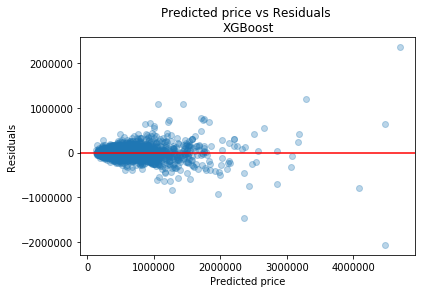

In [186]:
# Residuals vs Predicted price (by XGBoost)
y_pred =  xgb_trained.predict(X_test)
resid = y_test - y_pred
plt.scatter(y_pred, resid, alpha=.3)
plt.xlabel("Predicted price")
plt.ylabel("Residuals")
plt.title("Predicted price vs Residuals \nXGBoost")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [198]:
y_pred =  xgb_trained.predict(X_test)
resid = y_test - y_pred
sum(resid > 1000000)+sum(resid < -1000000)

6

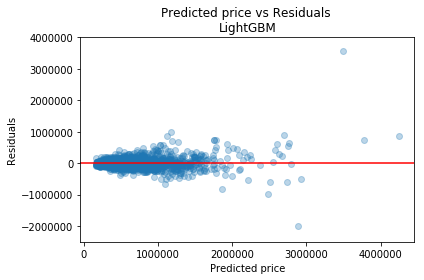

In [189]:
# Residuals vs Predicted price (by LighGBM)
y_pred =  lgbm_trained.predict(X_test)
resid = y_test - y_pred
plt.scatter(y_pred, resid, alpha=.3)
plt.xlabel("Predicted price")
plt.ylabel("Residuals")
plt.title("Predicted price vs Residuals \nLightGBM")
plt.axhline(y=0, color='r', linestyle='-')

plt.ylim((min(-2500000, min(resid)),max(4000000,max(resid))))
plt.xticks(range(0,5000000,1000000),range(0,5000000,1000000))
plt.tight_layout() # need for savefig
plt.savefig("Residuals_LightGBM.png",format="png", dpi=300)
plt.show()

In [201]:
y_pred =  lgbm_trained.predict(X_test)
resid = y_test - y_pred
sum(resid > 1000000)+sum(resid < -1000000)

2

In [215]:
[i for i, x in enumerate(resid) if (x > 1000000)]

[3426]

In [214]:
df[df.price == y_test[3426]]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sold_month_December,sold_month_February,sold_month_January,sold_month_July,sold_month_June,sold_month_March,sold_month_May,sold_month_November,sold_month_October,sold_month_September
3910,7062500.0,5,4.5,10040,37325,2.0,1,2,3,11,...,0,0,0,0,1,0,0,0,0,0


In [210]:
df[df.price == y_test[3426]].waterfront

3910    1
Name: waterfront, dtype: int64

In [221]:
print(df[df.price == y_test[3426]].lat,'\n',df[df.price == y_test[3426]].long)

3910    47.65
Name: lat, dtype: float64 
 3910   -122.214
Name: long, dtype: float64


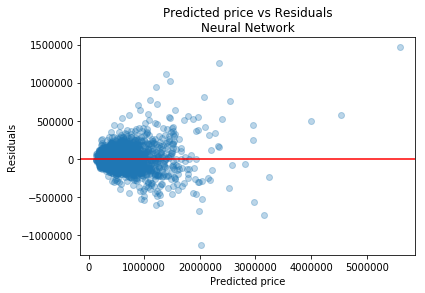

In [598]:
# Residuals vs Predicted price (by Neural network model)
y_pred =  history_model_4.model.predict(X_test_scaled).flatten()
resid = y_test - y_pred
plt.scatter(y_pred, resid, alpha=.3)
plt.xlabel("Predicted price")
plt.ylabel("Residuals")
plt.title("Predicted price vs Residuals\nNeural Network")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

The LightGBM makes less extreme residulas over 1 million or less than -1 million.

<a href='#Section0'>Go Back to the Table of Contents</a>